In [3]:
import configparser

# Create a ConfigParser object
config = configparser.ConfigParser()

# Load the configuration from the file
config.read('cfg.conf')

# Get the value of 'slide_path' under the section 'path_to_slide'
openslide_bin_path = config['path_to_slide']['openslide_path']
slide_photo_path = config['path_to_slide']['slide_local_path'] 
general_image_folder = config["images"]["general_path"]


In [4]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

if hasattr(os, 'add_dll_directory'):
    with os.add_dll_directory(openslide_bin_path):
        import openslide
else:
    import openslide

In [5]:
slide = openslide.OpenSlide(slide_photo_path)


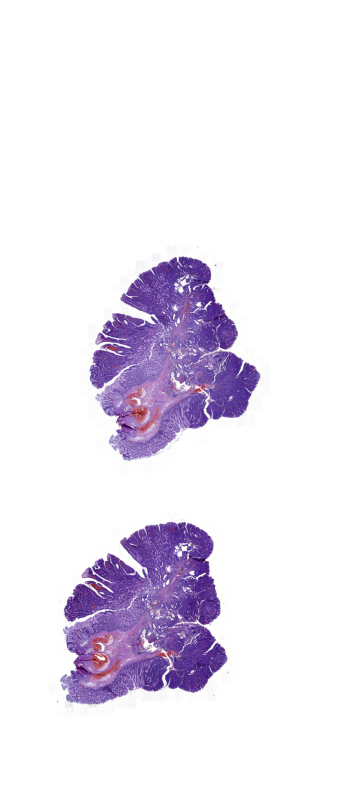

In [19]:
thumbnail_size = 1024
thumbnail = slide.get_thumbnail((thumbnail_size, thumbnail_size * slide.dimensions[1] // slide.dimensions[0]))

plt.figure(figsize=(10, 10))
plt.imshow(thumbnail)
plt.axis('off')  
plt.show()

In [20]:
def get_color_map(patch):
    
    r,g,b = patch.convert("RGB").split()
    r_array = np.array(r)
    g_array = np.array(g)
    b_array = np.array(b)


    #RED MASK
    red_diff_array = np.full_like(r_array, 30)
    red_mask = (r_array > cv2.add(b_array,red_diff_array) ) & (r_array > cv2.add(b_array,red_diff_array) )
    red_pixels = np.count_nonzero(red_mask)

    #ALL PIXLES
    pixels = np.count_nonzero(red_diff_array)

    #WHITE MASK 

    white_mask = (r_array>220)&(b_array>220)&(g_array>220)
    white_pixels = np.count_nonzero(white_mask)

    #BLACK MASK 
    black_mask = (r_array<30)&(b_array<30)&(g_array<30)
    black_pixels = np.count_nonzero(black_mask)

    #PURPLE MASK 
    purple_mask = (b_array>(cv2.add(r_array,g_array)))
    purple_pixels = np.count_nonzero(purple_mask)

    #PINK MASK
    average_pixels = (b_array.astype(int) + g_array.astype(int) + r_array.astype(int)) // 3
    pink_mask = (average_pixels > 150) & (average_pixels < 220)
    pink_pixels = np.count_nonzero(pink_mask)

    
    color_mask = np.zeros_like(r_array)
    color_mask[red_mask] = 120
    color_mask[white_mask] = 240
    color_mask[black_mask] = 10
    color_mask[purple_mask] = 60
    color_mask[pink_mask] = 180

    color_seperated_image = Image.fromarray(color_mask)
    
    return color_seperated_image, (pixels, white_pixels,red_pixels, black_pixels,purple_pixels,pink_pixels)



In [6]:
def divide_whole_slide_to_patches(slide, patch_size=(150, 150), offset=(0, 0), high_threshold=200, low_threshold=30, early_stop=True, early_stop_number=1000):
    slide_width, slide_height = slide.dimensions
    patch_width, patch_height = patch_size
    offset_x, offset_y = offset
    num = 1
    patches = []
    for y in range(offset_y, slide_height, int(patch_height / 2)):
        for x in range(offset_x, slide_width, int(patch_width / 2)):
            if x + patch_width > slide_width or y + patch_height > slide_height:
                continue  
            patch = slide.read_region((x, y), 0, patch_size)
            np_patch = np.array(patch)
            median_color = np.median(np_patch)
            if median_color < high_threshold and median_color > low_threshold:
                patches.append(patch)
                num += 1
            if early_stop and num > early_stop_number:
                return patches
    return patches

def extract_random_patches(slide, patch_size=(256, 256), num_patches=100, high_threshold = 200, low_threshold = 50):
    slide_width, slide_height = slide.dimensions
    patch_width, patch_height = patch_size
    patches = []

    while len(patches) < num_patches:
        x = np.random.randint(8192, slide_width - patch_width - 8192)
        y = np.random.randint(8192, slide_height - patch_height - 8192)
        
        patch = slide.read_region((x, y), 0, patch_size)
        
        np_patch = np.array(patch)
        median_color = np.median(np_patch)
        if median_color < high_threshold and median_color > low_threshold:
            patches.append(patch)        
            
    return patches





In [7]:
def save_patches_to_dir(patches, save_dir, base_folder = general_image_folder):
    save_dir = os.path.join(base_folder,save_dir)
    os.makedirs(save_dir, exist_ok=True)
    for index,patch in enumerate(patches):
        patch_filename = f"patch_{index}.tif"
        patch_path = os.path.join(save_dir, patch_filename)
        patch.save(patch_path)
    
def seperate_patches(patches, save_dir, base_folder = general_image_folder):
    os.makedirs(base_folder, exist_ok=True)
    save_dir = os.path.join(base_folder,save_dir)
    os.makedirs(save_dir, exist_ok=True)
    cancer_folder = os.path.join(save_dir, "Cancer")
    no_cancer_folder = os.path.join(save_dir, "No-Cancer")
    os.makedirs(cancer_folder, exist_ok=True)
    os.makedirs(no_cancer_folder, exist_ok=True)
    for index,patch in enumerate(patches):
        patch_filename = f'patch_{index}.png'
        _ , (pixels, white_pixels,red_pixels, black_pixels,purple_pixels,pink_pixels) = get_color_map(patch)
        
        #IN CASE YOU WANT TO CHECK PERCENTAGES
        # str_with_values =f"{len(patches)}_purpletoall_{purple_pixels/(pixels-white_pixels):.2f}__purple_{purple_pixels/pixels:.2f}_pink_{pink_pixels/pixels:.2f}"
        # patch_filename = f'{str_with_values}.png'
        
        if (purple_pixels/(pixels-white_pixels))>0.2 and purple_pixels/pink_pixels > 1.1:
            cancer_folder = os.path.join(save_dir, "Cancer")
            patch_path = os.path.join(cancer_folder, patch_filename)
            patch.save(patch_path)
        else:
            no_cancer_folder = os.path.join(save_dir, "No-Cancer")
            patch_path = os.path.join(no_cancer_folder, patch_filename)
            patch.save(patch_path)

In [25]:
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img.flatten())  
            labels.append(label)
        
    return images, labels

In [34]:
patches = divide_whole_slide_to_patches(slide)
save_patches_to_dir(patches,'all')

In [28]:
cancer_folder = os.path.join(general_image_folder, 'cancer')

no_cancer_folder = os.path.join(general_image_folder, 'no_cancer')

no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_folder, 0) 
cancer_images, cancer_labels = load_images_from_folder(cancer_folder, 1) 


X = np.array(no_cancer_images + cancer_images)
y = np.array(no_cancer_labels + cancer_labels)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_valid)


accuracy = accuracy_score(y_valid, y_pred)
print(f'Dokładność modelu na zbiorze walidacyjnym: {accuracy:.2f}')

Dokładność modelu na zbiorze walidacyjnym: 0.86


In [36]:
def classify_new_images(model, all_photos, cancer_folder, no_cancer_folder):
    all_photos_path = os.path.join(general_image_folder, all_photos)
    own_cancer_folder = os.path.join(general_image_folder, cancer_folder)
    os.makedirs(own_cancer_folder, exist_ok=True)
    own_no_cancer_folder = os.path.join(general_image_folder, no_cancer_folder)
    os.makedirs(own_no_cancer_folder, exist_ok=True)

    image_files = [f for f in os.listdir(all_photos_path) if os.path.isfile(os.path.join(all_photos_path, f))]

    for img_file in image_files:
        img_path = os.path.join(all_photos_path, img_file)
        img = cv2.imread(img_path)
        #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_flatten = img.flatten() 
        
        prediction = model.predict([img_flatten])[0]
        target_folder = own_cancer_folder if prediction == 1 else own_no_cancer_folder
        
        destination_path = os.path.join(target_folder, os.path.basename(img_path))
        
        cv2.imwrite(destination_path, img)
        print(f'Obraz {os.path.basename(img_path)} został sklasyfikowany jako {prediction} i zapisany do {target_folder}')

In [35]:
classify_new_images(svm_model,"all","own_cancer", "own_no_cancer")

Obraz patch_0.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_1.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_10.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_100.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_101.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_102.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_103.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_104.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_105.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_106.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_107.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_108.tif został sklasyfikowany jako 1 i zapisany do photos\own_cancer
Obraz patch_109.tif został sklasy

In [15]:
def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def preprocess_image_fragment(fragment):
    processed_fragment = fragment.flatten()  
    return processed_fragment

def mark_cancer_areas(image_path, trained_svm_model, window_size=(150, 150), step_size=32):
    
    image = cv2.imread(image_path)
    marked_image = image.copy()

    for (x, y, window) in sliding_window(image, step_size=step_size, window_size=window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue  

        fragment = preprocess_image_fragment(window)
        fragment = np.array([fragment])  
        prediction = trained_svm_model.predict(fragment)

        if prediction == 1:  
            cv2.rectangle(marked_image, (x, y), (x + window_size[0], y + window_size[1]), (0, 0, 255), 2)

    cv2.imshow("Marked Image", marked_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [16]:
slide_path = os.path.join(general_image_folder, "slide")
slide_path = os.path.join(slide_path, "test11.tif")

mark_cancer_areas(slide_path, svm_model)